In [1]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq

In [104]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-4, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = False
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.module.add_on_layers.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-3, 'weight_decay': 1e-4}
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        self.num_iteration = 0
        
        
    def get_heatmaps(self, batch_x, labels, pid):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        # proto_dist_: (batch_size, 1000, 49)
        all_distances = torch.amin(proto_dist_, axis=-1)
        # all_distances: (batch_size, 1000)
        target_p = [pid]
        #for i in range(all_distances.shape[1]):
        #    class_i = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
        #    if class_i == class_identity:
        #        target_p.append(i)
        
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        dists = all_distances[:, target_p]
        dists = torch.transpose(dists, 0, 1)
        
    
        # proto_dist: (1000, batch_size)
        proto_dist_numpy = proto_dist.detach().cpu().numpy()
        
        
        original_imgs = []
        rescaled_patterns = []
        
        for j in target_p:
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in range(len(batch_x)):
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist_numpy[j][i],axis=None), proto_dist_numpy[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist_numpy[j][i] + 1)/(proto_dist_numpy[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist_numpy[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist_numpy[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
            
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)
    
        return original_imgs, rescaled_patterns, dists
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns):
        
        num_p = len(imgs)
        assert num_p == len(patterns)
        batch_size = len(imgs[0])
        assert batch_size == len(patterns[0])
        
        with torch.no_grad():
            rewards = torch.empty((num_p, batch_size))
            for i in range(num_p):
                for j in range(batch_size):
                    img = np.array([imgs[i][j]])
                    img = np.transpose(img, (0, 3, 1, 2))
                    img = torch.from_numpy(img).cuda()
                
                    pattern = patterns[i][j]
                    pattern = np.array([pattern, pattern, pattern])
                    pattern = torch.from_numpy(np.array([pattern])).cuda()
                    reward = self.pf_model(img, pattern) 
                    rewards[i][j] = reward
                
        return rewards
        
    def joint_update(self, rewards, dists):
        #print(dists)
        
        assert rewards.shape[0] == len(dists)
        assert rewards.shape[1] == len(dists[0])
        
        self.policy_optimizer.zero_grad()
        loss = 0
        for i in range(rewards.shape[0]):
            for j in range(rewards.shape[1]):
                if dists[i][j] > 0:
                    loss -= (1 / (100*dists[i][j]+1)) * rewards[i][j]
                #elif dists[i][j] == 0:
                #    loss -= rewards[i][j]
        
        loss.backward()
        self.policy_optimizer.step()
        return 
    
    
    def run(self, batch_x, labels, pid):

        original_imgs, rescaled_patterns, dists = self.get_heatmaps(batch_x, labels, pid)
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        loss = self.joint_update(rewards, dists)
        
        
        
        return torch.mean(rewards)
   
    

In [105]:
def reselect_prototypes(a3c, reward_threshold, data_loader, original_imgs, patterns):
    # get the heatmaps by searching for the closest images in the entire dataset
    # can use different k values
    # heatmaps: (1000, 1, 224, 224, 3)
    # rewards: (1000,)
    prototype_shape = a3c.PPnet_multi.module.prototype_shape
    bad_prototype_idx = []
    rewards = a3c.get_rewards(original_imgs, patterns)
    for i in range(len(rewards)):
        if rewards[i] < reward_threshold:
            bad_prototype_idx.append(i)
    print("bad prototype number: ", len(bad_prototype_idx))
    global_max_rewards = np.zeros((200, 5))
    global_best_patches = torch.zeros((200, 5, 128, 1, 1)).cuda()
    
    class_comps = np.zeros((200, 5))
    
    for idx, (batch_x, labels) in tqdm(enumerate(data_loader)):
        a3c.PPnet_multi.eval()
        n_prototypes = a3c.PPnet_multi.module.num_prototypes
        prototype_shape = a3c.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = a3c.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        # conv_outs: (80, 128, 7, 7)
        conv_outs = a3c.PPnet_multi.module.conv_features(batch_x)

        # loop over each prototype
        for j in bad_prototype_idx:
            class_identity = torch.argmax(a3c.PPnet_multi.module.prototype_class_identity[j])
            batch_idx = np.arange(batch_x.shape[0])
            class_idx_batch = batch_idx[labels == class_identity]
            #print(class_idx_batch)
            class_outs = conv_outs[labels == class_identity]
            if class_outs.shape[0] == 0:
                continue
            height = class_outs.shape[2]
            width = class_outs.shape[3]
            
            for img_idx in range(class_outs.shape[0]):
                img_max_reward = 0
                img_best_patch = a3c.PPnet_multi.module.prototype_vectors.data[j]
                for h in range(height):
                    for w in range(width):
                        # actually old_vec might not be necessary
                        # old_vec = np.copy(a3c.PPnet_multi.module.prototype_vectors.data[j])
                        patch_candidate = class_outs[img_idx, :, h:h+1, w:w+1]
                        a3c.PPnet_multi.module.prototype_vectors.data[j] = patch_candidate
                        #a3c.PPnet_multi.module.prototype_vectors.data.copy_(vec)
                        # distances: (7, 7)
                        distances = a3c.PPnet_multi.module._l2_convolution(class_outs[img_idx])[j].detach().cpu().numpy()
                        
                        if a3c.PPnet_multi.module.prototype_activation_function == 'log':
                            act_pattern = np.log((distances + 1)/(distances + a3c.PPnet_multi.module.epsilon))
                        elif a3c.PPnet_multi.module.prototype_activation_function == 'linear':
                            act_pattern = max_dist - distances
                        else:
                            act_pattern = prototype_activation_function_in_numpy(distances)
                            
                        upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                        rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                        rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                        
                        img = torch.unsqueeze(batch_x[class_idx_batch[img_idx]], 0)
                        pattern = torch.tensor([rescaled_act_pattern, rescaled_act_pattern, rescaled_act_pattern])
                        pattern = torch.unsqueeze(pattern, 0)
                        
                        
                        patch_reward = a3c.pf_model(img, pattern.cuda()) + 15
                        
                        if patch_reward > img_max_reward:
                            img_max_reward = patch_reward
                            img_best_patch = patch_candidate
                        #else:
                        #    a3c.PPnet_multi.module.prototype_vectors.data[j] = old_vec
                            
                
                min_index = int(class_comps[class_identity][-1])
                if img_max_reward > global_max_rewards[class_identity][min_index]:
                    global_max_rewards[class_identity][min_index] = img_max_reward
                    global_best_patches[class_identity][min_index] = img_best_patch
                    class_comps[class_identity] = np.flip(np.argsort(global_max_rewards[class_identity]))
                   
  
    for i in bad_prototype_idx:
        class_num = int(i // 5)
        p_num = int(class_comps[class_num][0])
        class_comps[class_num] = np.roll(class_comps[class_num], -1)
        a3c.PPnet_multi.module.prototype_vectors.data[i] = global_best_patches[class_num][p_num]
        
    return global_max_rewards

In [106]:
class ImagePatch:

    def __init__(self, patch, label, distance,
                 original_img=None, act_pattern=None, patch_indices=None):
        self.patch = patch
        self.label = label
        self.negative_distance = -distance

        self.original_img = original_img
        self.act_pattern = act_pattern
        self.patch_indices = patch_indices

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance


class ImagePatchInfo:

    def __init__(self, label, distance):
        self.label = label
        self.negative_distance = -distance

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance

def find_k_nearest_patches_to_prototypes(dataloader, # pytorch dataloader (must be unnormalized in [0,1])
                                         prototype_network_parallel, # pytorch network with prototype_vectors
                                         k=3,
                                         preprocess_input_function=None, # normalize if needed
                                         full_save=False, # save all the images
                                         root_dir_for_saving_images='./nearest',
                                         log=print,
                                         prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0):
    prototype_network_parallel.eval()
    '''
    full_save=False will only return the class identity of the closest
    patches, but it will not save anything.
    '''
    log('find nearest patches')
    start = time.time()
    n_prototypes = prototype_network_parallel.module.num_prototypes
    
    prototype_shape = prototype_network_parallel.module.prototype_shape
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

    protoL_rf_info = prototype_network_parallel.module.proto_layer_rf_info

    heaps = []
    # allocate an array of n_prototypes number of heaps
    for _ in range(n_prototypes):
        # a heap in python is just a maintained list
        heaps.append([])

    for idx, (search_batch_input, search_y) in tqdm(enumerate(dataloader)):
        #print('batch {}'.format(idx))
        if preprocess_input_function is not None:
            # print('preprocessing input for pushing ...')
            # search_batch = copy.deepcopy(search_batch_input)
            search_batch = preprocess_input_function(search_batch_input)

        else:
            search_batch = search_batch_input

        with torch.no_grad():
            search_batch = search_batch.cuda()
            protoL_input_torch, proto_dist_torch = \
                prototype_network_parallel.module.push_forward(search_batch)

        #protoL_input_ = np.copy(protoL_input_torch.detach().cpu().numpy())
        proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())
        
        # proto_dist_: (80, 1000, 7, 7)

        for img_idx, distance_map in enumerate(proto_dist_):
            for j in range(n_prototypes):
                # find the closest patches in this batch to prototype j

                closest_patch_distance_to_prototype_j = np.amin(distance_map[j])



                closest_patch_indices_in_distance_map_j = \
                    list(np.unravel_index(np.argmin(distance_map[j],axis=None),
                                          distance_map[j].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                closest_patch_indices_in_img = \
                    compute_rf_prototype(search_batch.size(2),
                                         closest_patch_indices_in_distance_map_j,
                                         protoL_rf_info)
                closest_patch = \
                    search_batch_input[img_idx, :,
                                       closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2],
                                       closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = search_batch_input[img_idx].numpy()
                original_img = np.transpose(original_img, (1, 2, 0))

                if prototype_network_parallel.module.prototype_activation_function == 'log':
                    act_pattern = np.log((distance_map[j] + 1)/(distance_map[j] + prototype_network_parallel.module.epsilon))
                elif prototype_network_parallel.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - distance_map[j]
                else:
                    act_pattern = prototype_activation_function_in_numpy(distance_map[j])

                # 4 numbers: height_start, height_end, width_start, width_end
                patch_indices = closest_patch_indices_in_img[1:5]

                # construct the closest patch object
                closest_patch = ImagePatch(patch=closest_patch,
                                           label=search_y[img_idx],
                                           distance=closest_patch_distance_to_prototype_j,
                                           original_img=original_img,
                                           act_pattern=act_pattern,
                                           patch_indices=patch_indices)
                '''
                else:
                
                closest_patch = ImagePatchInfo(label=search_y[img_idx],
                                                   distance=closest_patch_distance_to_prototype_j)
                '''

                # add to the j-th heap 
                if len(heaps[j]) < k:
                    heapq.heappush(heaps[j], closest_patch)
                else:
                    # heappushpop runs more efficiently than heappush
                    # followed by heappop
                    heapq.heappushpop(heaps[j], closest_patch)
                    

    # after looping through the dataset every heap will
    # have the k closest prototypes
    original_imgs = []
    patterns = []
    for j in range(n_prototypes):
        # finally sort the heap; the heap only contains the k closest
        # but they are not ranked yet
        heaps[j].sort()
        heaps[j] = heaps[j][::-1]

        original_imgs_j = []
        patterns_j = []
        for i, patch in enumerate(heaps[j]):
            
            img_size = patch.original_img.shape[0]
            upsampled_act_pattern = cv2.resize(patch.act_pattern,
                                               dsize=(img_size, img_size),
                                               interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
            
            # No need for these if using dummy reward model
            '''
            heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[...,::-1]

            overlayed_original_img = 0.5 * patch.original_img + heatmap_ratio * heatmap
            overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
            overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
            '''
            original_imgs_j.append(patch.original_img)
            patterns_j.append(rescaled_act_pattern)
            
        original_imgs.append(original_imgs_j)
        patterns.append(patterns_j)
    end = time.time()
    log('\tfind nearest patches time: \t{0}'.format(end - start))

    return original_imgs, patterns

In [107]:
from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features
from receptive_field import compute_proto_layer_rf_info_v2
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=False,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 1):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
                
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias
    

        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.final_fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        
            )
        
        #self.fc1 = nn.Linear(6400, 512)
        #self.fc2 = nn.Linear(512, 32)
        #self.fc3 = nn.Linear(32, 1)
        #self.fc1 = nn.Linear(64, 16)
        

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        #print("base features: ", x.shape)
        #x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        #x = self.conv_features(x)
        x = self.img_features(x)
        #x = self.add_on_layers(x)
        x = self.img_conv(x)
        #print("conv out:", x.shape)
        p = self.pattern_features(p)
        #p = self.conv_features(p)
        #p = self.add_on_layers(p)
        p = self.pattern_conv(p)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) 
        #print("flatten out shape: ", out.shape)
        
        out = self.final_fc(out)
        #out = torch.sigmoid(self.fc1(out))
        #out = torch.sigmoid(self.fc2(out))
        #out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.img_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(1000, 128, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 1):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                   pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss


In [113]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
ppnet = torch.nn.DataParallel(ppnet)
#pf_model = construct_PrefNet("resnet18")
#pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')
pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')

In [114]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)

aug_train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

aug_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

In [94]:
indices = []

'''
Each batch of size 80 consists of 16 shuffled blocks
'''
#for i in range(200):
#    class_i = [ind for ind, ele in enumerate(train_dataset.targets) if ele == i]
#    indices.append(class_i[:10])
#    indices.append(class_i[10:20])
#    indices.append(class_i[20:])
    
    #indices.append(class_i[:5])
    #indices.append(class_i[5:10])
    #indices.append(class_i[10:15])
    #indices.append(class_i[15:20])
    #indices.append(class_i[20:25])
    #indices.append(class_i[25:])

class_p_idx = 4
class_i = [ele for ind, ele in enumerate(train_dataset.targets) if ind == 5163][0]
class_0 = [ind for ind, ele in enumerate(train_dataset.targets) if ele == class_i]
print(class_i)
print(class_0)

172
[5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186]


In [115]:
a3c = A3C_PPnet(ppnet, pf_model)

In [96]:
#avg_reward = []
p_rewards = []

In [97]:
old_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data)

In [98]:
'''
Human feedback training with reselection
'''
shuffled_idx = class_0
shuffled_dataset = Subset(train_dataset, shuffled_idx)

dataloader = torch.utils.data.DataLoader(
shuffled_dataset, batch_size=32, shuffle=False,
num_workers=2, pin_memory=False)

# single batch update on training data
batch, label = next(iter(dataloader))
for i in range(100):
    avg_reward = a3c.run(batch, label, class_i*5+class_p_idx)
    print("Iter " + str(i) + " avg reward: " + str(avg_reward))

for i in range(len(old_vec)):
    if i != class_i*5+class_p_idx:
        a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]

'''
for epoch in range(100):
    
    #if epoch in [20, 50]:
    #    original_imgs, patterns = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)
    #    global_max_rewards = reselect_prototypes(a3c, -5, train_loader, original_imgs, patterns)
    
    #order = np.random.permutation(600)
    #shuffled_idx = []
    #for idx in order:
    #    shuffled_idx += indices[idx]
    
    # only update a particular class to see the performance
    
    epoch_reward = 0
    for i, (batch, label) in tqdm(enumerate(dataloader)):
        
        avg_reward = a3c.run(batch, label, class_i*5+class_p_idx)
        epoch_reward += avg_reward
    p_rewards.append(epoch_reward)
    print("Epoch " + str(epoch) + " average reward: " + str(epoch_reward / i))    
'''
        #print(epoch_reward)
        #print("Epoch "+str(epoch)+" Iteration "+str(i)+" total expected reward: ", total_reward)
        #print("Epoch "+str(epoch)+" Iteration "+str(i)+" total mse loss: ", mse_loss)
    
    #print("Epoch "+str(a3c.num_epoch)+" "+str(i)+" average reward: ", epoch_reward/i)
    
    #avg_reward.append(epoch_reward/i)

Iter 0 avg reward: tensor(0.8273)
Iter 1 avg reward: tensor(0.8210)
Iter 2 avg reward: tensor(0.8199)
Iter 3 avg reward: tensor(0.8183)
Iter 4 avg reward: tensor(0.8170)
Iter 5 avg reward: tensor(0.8162)
Iter 6 avg reward: tensor(0.8157)
Iter 7 avg reward: tensor(0.8129)
Iter 8 avg reward: tensor(0.8112)
Iter 9 avg reward: tensor(0.8102)
Iter 10 avg reward: tensor(0.8096)
Iter 11 avg reward: tensor(0.8080)
Iter 12 avg reward: tensor(0.8066)
Iter 13 avg reward: tensor(0.8057)
Iter 14 avg reward: tensor(0.8056)
Iter 15 avg reward: tensor(0.8058)
Iter 16 avg reward: tensor(0.8058)
Iter 17 avg reward: tensor(0.8062)
Iter 18 avg reward: tensor(0.8066)
Iter 19 avg reward: tensor(0.8070)
Iter 20 avg reward: tensor(0.8074)
Iter 21 avg reward: tensor(0.8074)
Iter 22 avg reward: tensor(0.8073)
Iter 23 avg reward: tensor(0.8070)
Iter 24 avg reward: tensor(0.8067)
Iter 25 avg reward: tensor(0.8063)
Iter 26 avg reward: tensor(0.8086)
Iter 27 avg reward: tensor(0.8116)
Iter 28 avg reward: tensor(0.8

'\nfor epoch in range(100):\n    \n    #if epoch in [20, 50]:\n    #    original_imgs, patterns = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)\n    #    global_max_rewards = reselect_prototypes(a3c, -5, train_loader, original_imgs, patterns)\n    \n    #order = np.random.permutation(600)\n    #shuffled_idx = []\n    #for idx in order:\n    #    shuffled_idx += indices[idx]\n    \n    # only update a particular class to see the performance\n    \n    epoch_reward = 0\n    for i, (batch, label) in tqdm(enumerate(dataloader)):\n        \n        avg_reward = a3c.run(batch, label, class_i*5+class_p_idx)\n        epoch_reward += avg_reward\n    p_rewards.append(epoch_reward)\n    print("Epoch " + str(epoch) + " average reward: " + str(epoch_reward / i))    \n'

In [116]:
'''
Update each prototype
'''
for p_idx in range(1000):
    start = time.time()
    old_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data)
    class_idx = p_idx // 5
    class_imgs = [x for x, y in enumerate(train_dataset.targets) if y == class_idx]
    class_dataset = Subset(train_dataset, class_imgs)

    dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
    batch, label = next(iter(dataloader))
    best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
    best_iter = 0
    best_reward = a3c.run(batch, label, p_idx)
    initial_reward = best_reward
    if initial_reward < 0.1 or initial_reward > 0.8:
        continue
    print("Prototype: " + str(p_idx) + " initial reward: " + str(initial_reward))
    convergence_counter = 0
    for i in range(1000):
        avg_reward = a3c.run(batch, label, p_idx)
        if avg_reward > best_reward:
            convergence_counter = 0
            best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
            best_iter = i
            best_reward = avg_reward
        convergence_counter += 1
        if convergence_counter > 150:
            break
    
    a3c.PPnet_multi.module.prototype_vectors.data[p_idx] = best_vec
    end = time.time()
    print("Prototype: " + str(p_idx) + " best reward: " + str(best_reward) + " iter: " + str(best_iter) + " time: " + str(end - start))
    for i in range(len(old_vec)):
        if i != p_idx:
            a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
    
    
    

Prototype: 0 initial reward: tensor(0.5103)
Prototype: 0 best reward: tensor(0.5103) iter: 0 time: 169.41105389595032
Prototype: 1 initial reward: tensor(0.5772)
Prototype: 1 best reward: tensor(0.5772) iter: 0 time: 169.81590747833252
Prototype: 2 initial reward: tensor(0.3508)
Prototype: 2 best reward: tensor(0.3725) iter: 9 time: 179.68184161186218
Prototype: 3 initial reward: tensor(0.3983)
Prototype: 3 best reward: tensor(0.4268) iter: 8 time: 180.14159226417542
Prototype: 4 initial reward: tensor(0.2731)
Prototype: 4 best reward: tensor(0.2732) iter: 6 time: 177.00255584716797
Prototype: 5 initial reward: tensor(0.4152)
Prototype: 5 best reward: tensor(0.4618) iter: 13 time: 179.5882499217987
Prototype: 6 initial reward: tensor(0.4270)
Prototype: 6 best reward: tensor(0.4319) iter: 2 time: 167.03519201278687
Prototype: 7 initial reward: tensor(0.4386)
Prototype: 7 best reward: tensor(0.4621) iter: 53 time: 222.2141354084015
Prototype: 8 initial reward: tensor(0.4006)
Prototype: 8

KeyboardInterrupt: 

In [117]:
torch.save(a3c.PPnet_multi.module, r'./A3C_results/joint_001_231.pth')

In [79]:
#plt.plot(np.arange(70), p_rewards)

In [99]:
'''
Visualize the effect of updates
'''
def visualize_updated_prototype(ppnet, pid, k):
    target_dataset = Subset(train_dataset, [pid])

    dataloader = torch.utils.data.DataLoader(
    target_dataset, batch_size=1, shuffle=False,
    num_workers=2, pin_memory=False)

    batch, label = next(iter(dataloader))
    batch_x = batch[0].cuda()
    protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(batch_x)
    proto_dist = proto_dist_torch.detach().cpu().numpy()

    class_identity = label[0]
        
    act_pattern = np.log((proto_dist[class_identity * 5 + k] + 1)/(proto_dist[class_identity * 5 + k] + ppnet.module.epsilon))
    upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
    rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
    heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    original_img = batch_x.cpu().numpy()
    original_img = np.transpose(original_img, (1, 2, 0))
    overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)


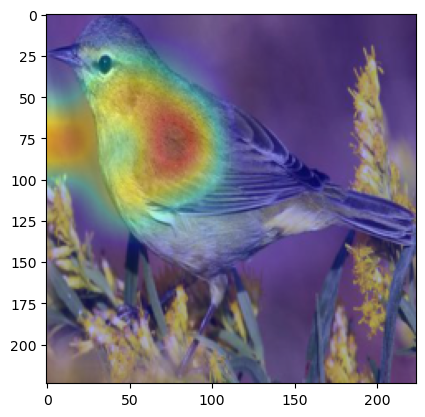

In [101]:
visualize_updated_prototype(a3c.PPnet_multi, 5163, 4)

In [15]:
def visualize_img_pattern(p_dir, pid):
    img = skio.imread('./human_comparisons/feedback_images/'+p_dir+'/original_imgs/'+pid+'.png')
    img = sk.img_as_float(img)
    pattern = np.load('./human_comparisons/feedback_images/'+p_dir+'/patterns/'+pid+'.npy')
    heatmap = cv2.applyColorMap(np.uint8(255*pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlayed_original_img = 2.0 * img[:, :, :3] + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)

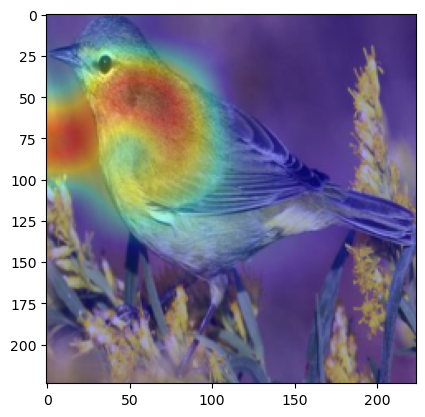

In [102]:
visualize_img_pattern('k=1_random', '5163_4')